In [14]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:
#Import CDO and make sure it works
from cdo import *

#--Initialize CDO
cdo=Cdo()

%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import matplotlib.colors as colors
import collections

os.chdir('/net2/jwb/STEP/')

In [16]:
#Correlation Calculation for Many Definitions
corr = collections.defaultdict(dict)
xns = ['n']
days = ['3114']
pctns = ['90']
direc = '/archive/jwb'

for defxn in xns:
    for defday in days:
        for pctn in pctns:

            files = {'XYTave0':direc+'/STEP/MERRA/Shift_0_fix/tn90pct_heatwaves_MERRA_r0_3114_yearly_summer.nc',
            'XYTave1-5':direc+'/STEP/MERRA/Shift_1-5_fix/tn90pct_heatwaves_MERRA_r0_3114_yearly_summer.nc',
            'XYTave2':direc+'/STEP/MERRA/Shift_2_fix/tn90pct_heatwaves_MERRA_r0_3114_yearly_summer.nc',
            'XYTave2xCO2':direc+'/STEP/MERRA/Shift_2xCO2_fix/tn90pct_heatwaves_MERRA_r0_3114_yearly_summer.nc'}

            head = 'tn90pct' #files['XYTave0'][41:48]

            ahwf0 = {}
            ahwf = {}
            ahw2f = {}
            cp = {}
            cp_diff = {}
            ahwfp = {}
    
            for key, value in files.iteritems():
                ahwf0[key] = cdo.timmean(input = '-selvar,%s %s' %('AHWF_'+head,value),output = key+'_ahwf_'+defday+defxn+pctn+'.nc',
                               options='-f nc', returnCdf=True)
                ahwf[key] = np.squeeze(ahwf0[key]['AHWF_'+head][:])
                ahw2f[key] = cdo.timmean(input = '-selvar,%s %s' %('AHW2F_'+head,value),output = key+'_ahw2f_'+defday+defxn+pctn+'.nc',
                               options='-f nc', returnCdf=True)
                ahw2f[key] = np.squeeze(ahw2f[key]['AHW2F_'+head][:])
                cp[key] = cdo.mulc(100,input = '-div %s %s' %(key+'_ahw2f_'+defday+defxn+pctn+'.nc',key+'_ahwf_'+defday+defxn+pctn+'.nc'), 
                           output = key+'_cp_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True)
                cp[key] = np.squeeze(cp[key]['AHW2F_'+head][:])
                ahwfp[key] = ahwf[key]/153*100

            for key in ['XYTave1-5','XYTave2','XYTave2xCO2']:
                cp_diff[key] = cdo.sub(input = '%s %s' %(key+'_cp_'+defday+defxn+pctn+'.nc','XYTave0_cp_'+defday+defxn+pctn+'.nc'), 
                               output = key+'_cp_diff_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True)
                cp_diff[key] = np.squeeze(cp_diff[key]['AHW2F_'+head][:])

lats0 = ahwf0['XYTave0']['lat'][:]
lons0 = ahwf0['XYTave0']['lon'][:]                

In [17]:
#Calculates means

lat_s = -90
lat_n = 90
lon_w = 0
lon_e = 360

mlats = np.transpose(np.tile(lats0,(lons0.shape[0],1)))
weights = np.cos(np.deg2rad(mlats))
mlons = np.tile(lons0,(lats0.shape[0],1))
lats_mask = np.logical_and(mlats >= lat_s, mlats <= lat_n)
lons_mask = np.logical_and(mlons >= lon_w, mlons <= lon_e)
reg_mask = lats_mask*lons_mask

def spacemean(var):
    regmean = np.ma.average(var[reg_mask], weights = weights[reg_mask])
    return regmean

lat_0 = lats0.mean()
lon_0 =  lons0.mean()

parallels = np.arange(-90.,90,30.)
meridians = np.arange(0.,360.,60.)

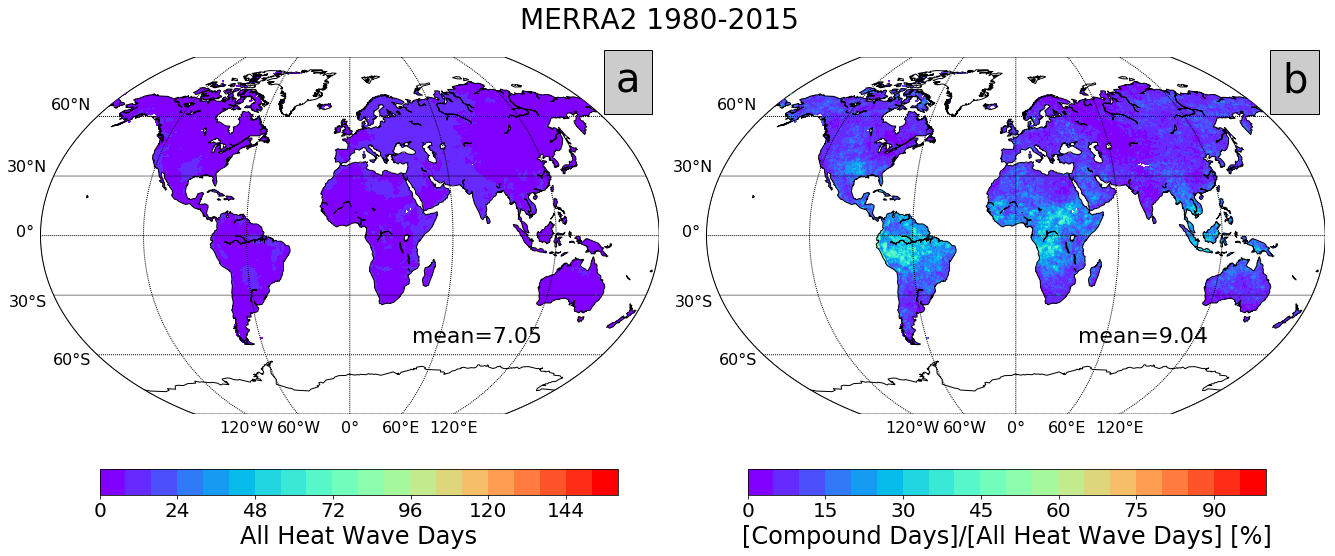

In [18]:
#Mean Maps
fig = plt.figure(figsize=(18,12))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 0
x1 = start+sf
lon0 = start+180+sf

ax1 = plt.subplot(1,2,1)
var = ahwf['XYTave0']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
bounds=np.linspace(0,160,21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=plt.cm.rainbow)
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax2 = plt.subplot(1,2,2)
var = cp['XYTave0']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(0,100,21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
csp = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=plt.cm.rainbow)
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax1.text(1,1.1, "MERRA2 1980-2015", transform=ax1.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')

ax1.text(0.93,0.9, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax2.text(0.93,0.9, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([0.05, 0.2, 0.4, 0.03])
art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('All Heat Wave Days', fontsize=24)
art.ax.tick_params(labelsize=20)
caxp = fig.add_axes([0.55, 0.2, 0.4, 0.03])
art2 = plt.colorbar(csp, caxp, orientation='horizontal')
art2.set_label('[Compound Days]/[All Heat Wave Days] [%]', fontsize=24)
art2.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=4, h_pad=0.2)

fig.savefig(defxn+defday+pctn+'_MERRA2mean.pdf',bbox_inches='tight')

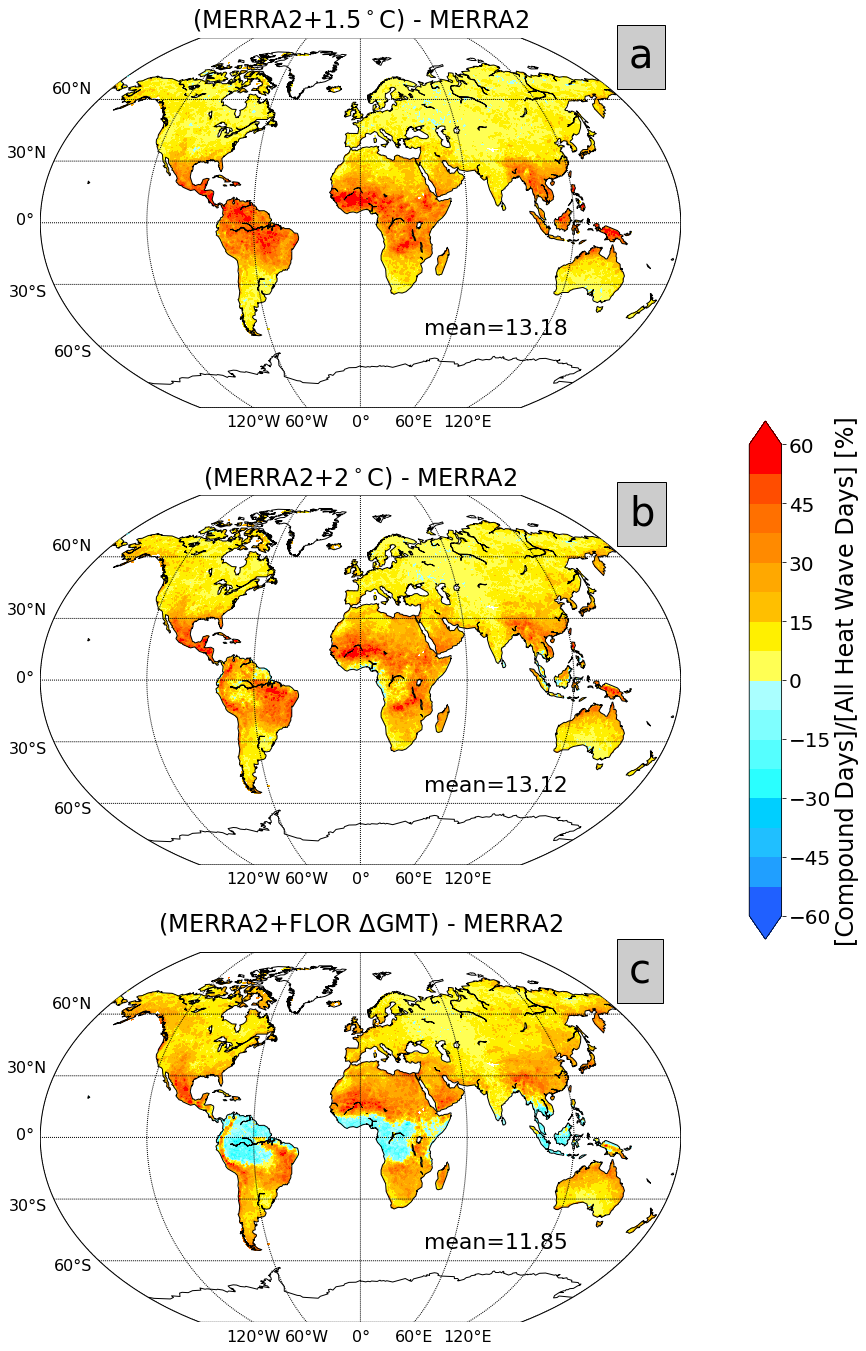

In [19]:
#Difference Maps

fig = plt.figure(figsize=(9,18))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 0
x1 = start+sf
lon0 = start+180+sf

ax1 = plt.subplot(3,1,1)
var = cp_diff['XYTave1-5']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax2 = plt.subplot(3,1,2)
var = cp_diff['XYTave2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax3 = plt.subplot(3,1,3)
var = cp_diff['XYTave2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax3.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax3.transAxes,fontsize=22)

ax1.text(0.5,1.05, "(MERRA2+1.5$^\circ$C) - MERRA2", transform=ax1.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax2.text(0.5,1.05, "(MERRA2+2$^\circ$C) - MERRA2", transform=ax2.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax3.text(0.5,1.08, "(MERRA2+FLOR $\Delta$GMT) - MERRA2", transform=ax3.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')

ax1.text(0.919,0.919, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax2.text(0.919,0.919, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax3.text(0.919,0.919, "c", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([1.1, 0.3, 0.05, 0.4])
art = plt.colorbar(cs, cax, orientation='vertical')
art.set_label('[Compound Days]/[All Heat Wave Days] [%]', fontsize=24)
art.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=2.5, h_pad=8)

fig.savefig(defxn+defday+pctn+'_MERRA2diff.pdf', bbox_inches='tight')

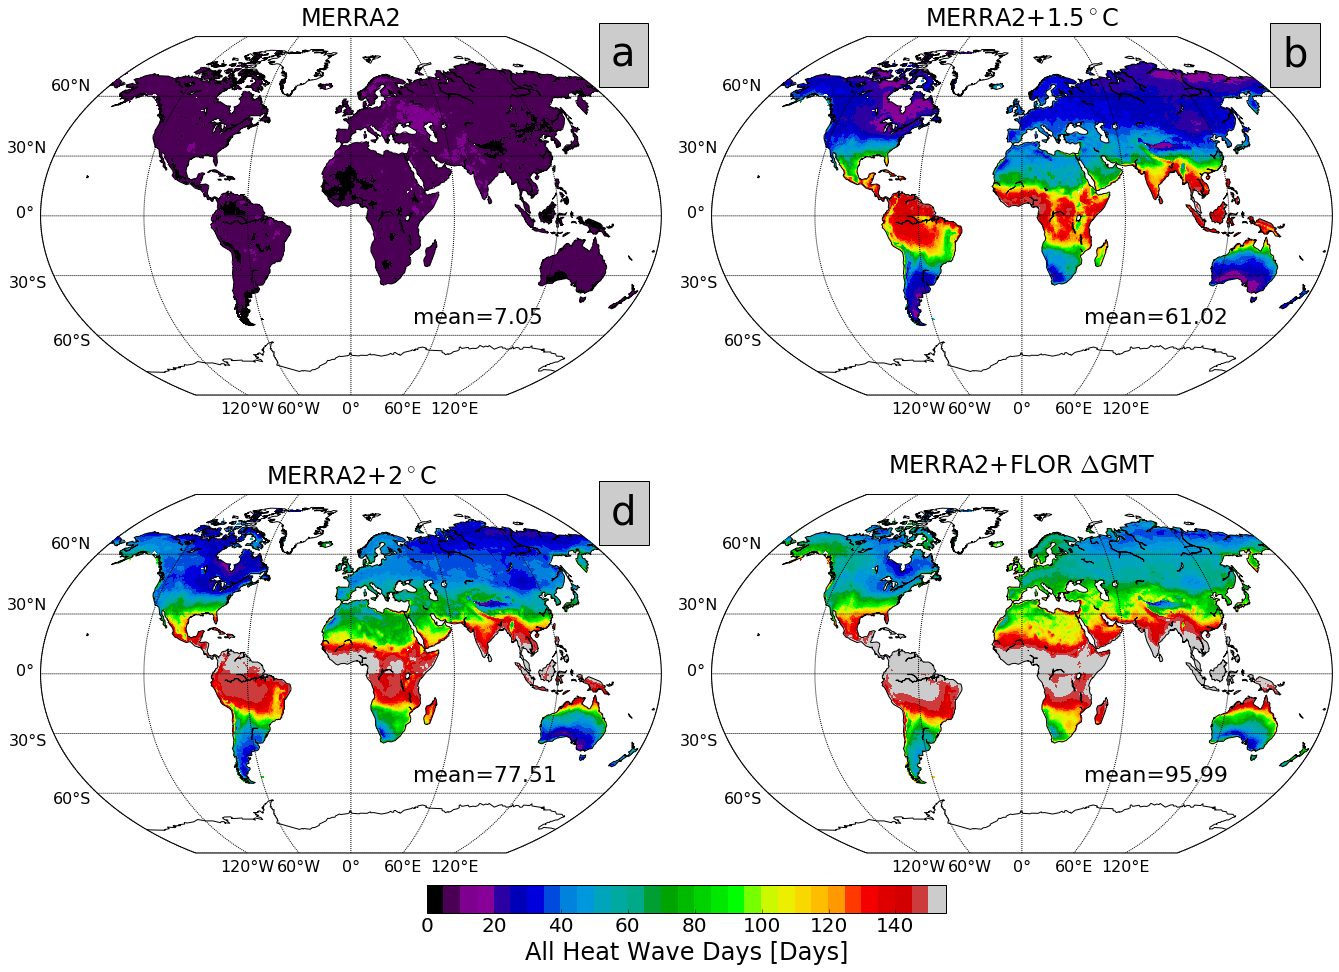

In [13]:
#All Heat Wave Days

fig = plt.figure(figsize=(18,13))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 0
x1 = start+sf
lon0 = start+180+sf

bounds = np.arange(0,160,5)
cmap = plt.cm.nipy_spectral

ax1 = plt.subplot(2,2,1)
var = ahwf['XYTave0']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax2 = plt.subplot(2,2,2)
var = ahwf['XYTave1-5']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax3 = plt.subplot(2,2,3)
var = ahwf['XYTave2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax3.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax3.transAxes,fontsize=22)

ax4 = plt.subplot(2,2,4)
var = ahwf['XYTave2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax4.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax4.transAxes,fontsize=22)

ax1.text(0.5,1.05, "MERRA2", transform=ax1.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax2.text(0.5,1.05, "MERRA2+1.5$^\circ$C", transform=ax2.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax3.text(0.5,1.05, "MERRA2+2$^\circ$C", transform=ax3.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax4.text(0.5,1.08, "MERRA2+FLOR $\Delta$GMT", transform=ax4.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')

ax1.text(0.919,0.919, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax2.text(0.919,0.919, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax3.text(0.919,0.919, "c", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax4.text(0.919,0.919, "d", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([0.3, 0.0, 0.4, 0.03])
art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('All Heat Wave Days [Days]', fontsize=24)
art.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=5, h_pad=5)

fig.savefig(defxn+defday+pctn+'_MERRA2AHWF.png', bbox_inches='tight')

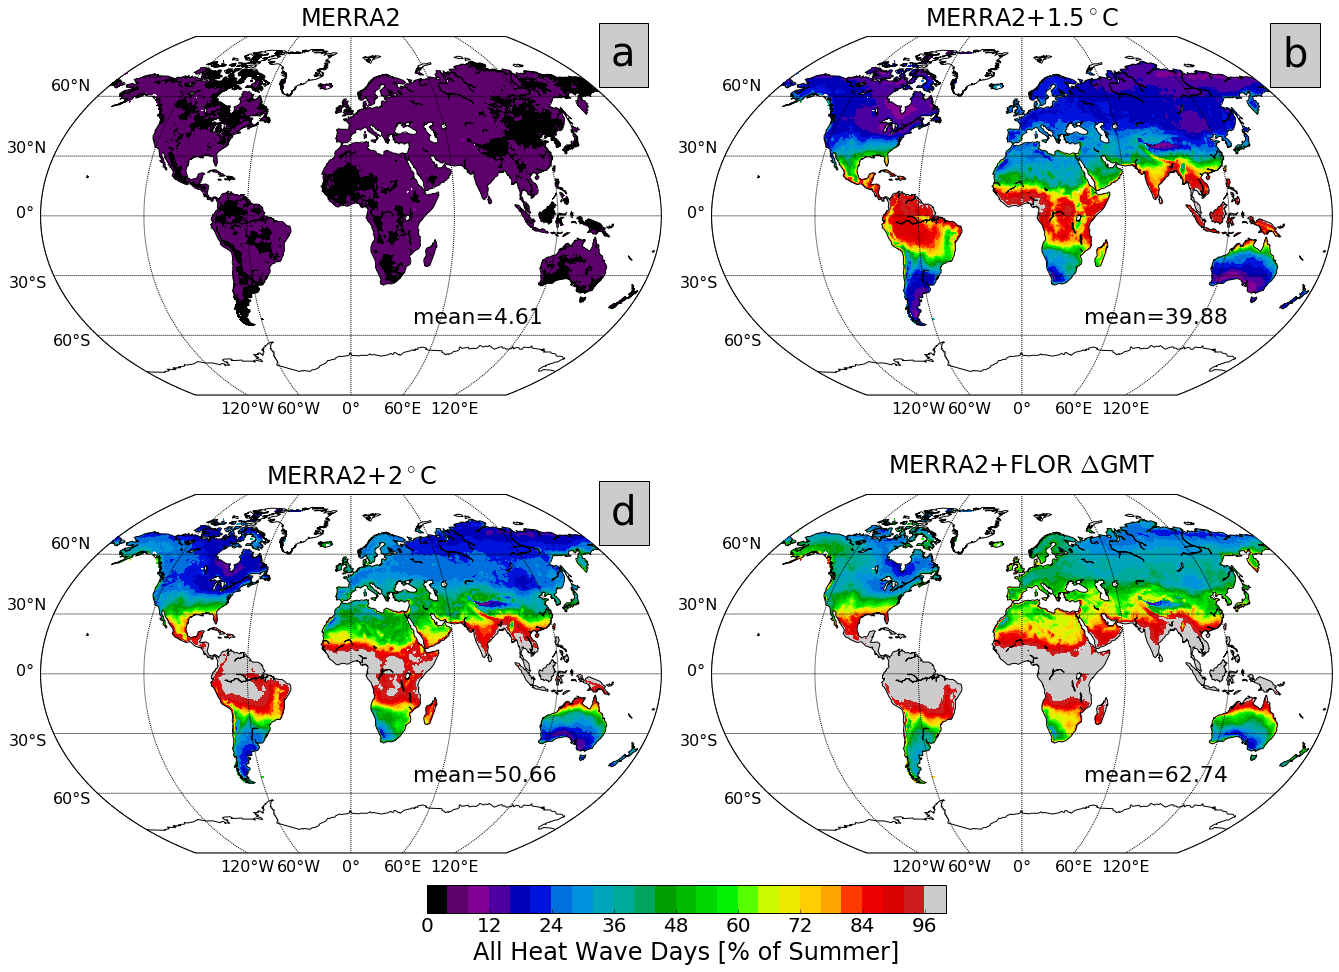

In [12]:
#All Heat Wave Days As Percent of Total (153 days per summer)

fig = plt.figure(figsize=(18,13))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 0
x1 = start+sf
lon0 = start+180+sf

bounds = np.arange(0,104,4)
cmap = plt.cm.nipy_spectral

ax1 = plt.subplot(2,2,1)
var = ahwfp['XYTave0']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax2 = plt.subplot(2,2,2)
var = ahwfp['XYTave1-5']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax3 = plt.subplot(2,2,3)
var = ahwfp['XYTave2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax3.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax3.transAxes,fontsize=22)

ax4 = plt.subplot(2,2,4)
var = ahwfp['XYTave2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap)
ax4.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax4.transAxes,fontsize=22)

ax1.text(0.5,1.05, "MERRA2", transform=ax1.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax2.text(0.5,1.05, "MERRA2+1.5$^\circ$C", transform=ax2.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax3.text(0.5,1.05, "MERRA2+2$^\circ$C", transform=ax3.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax4.text(0.5,1.08, "MERRA2+FLOR $\Delta$GMT", transform=ax4.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')

ax1.text(0.919,0.919, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax2.text(0.919,0.919, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax3.text(0.919,0.919, "c", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax4.text(0.919,0.919, "d", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([0.3, 0.0, 0.4, 0.03])
art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('All Heat Wave Days [% of Summer]', fontsize=24)
art.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=5, h_pad=5)

fig.savefig(defxn+defday+pctn+'_MERRA2AHWFP.png', bbox_inches='tight')

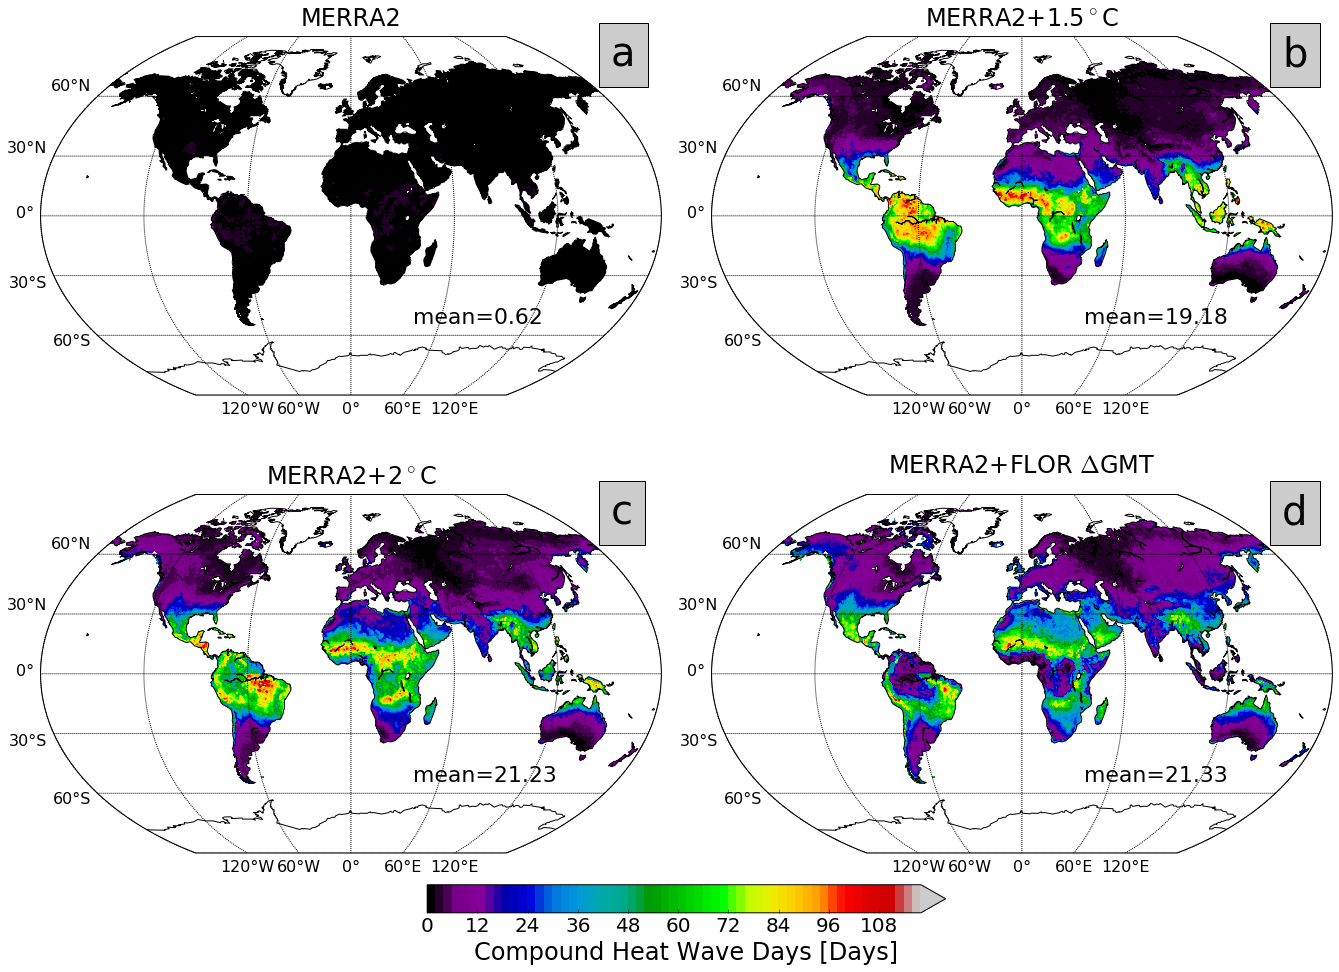

In [11]:
#Compound Heat Wave Days

fig = plt.figure(figsize=(18,13))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 0
x1 = start+sf
lon0 = start+180+sf

bounds = np.arange(0,120,2)
cmap = plt.cm.nipy_spectral

ax1 = plt.subplot(2,2,1)
var = ahw2f['XYTave0']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap,extend='max')
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax2 = plt.subplot(2,2,2)
var = ahw2f['XYTave1-5']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap,extend='max')
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax3 = plt.subplot(2,2,3)
var = ahw2f['XYTave2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap,extend='max')
ax3.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax3.transAxes,fontsize=22)

ax4 = plt.subplot(2,2,4)
var = ahw2f['XYTave2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cmap,extend='max')
ax4.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax4.transAxes,fontsize=22)

ax1.text(0.5,1.05, "MERRA2", transform=ax1.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax2.text(0.5,1.05, "MERRA2+1.5$^\circ$C", transform=ax2.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax3.text(0.5,1.05, "MERRA2+2$^\circ$C", transform=ax3.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')
ax4.text(0.5,1.08, "MERRA2+FLOR $\Delta$GMT", transform=ax4.transAxes, fontsize=24, rotation='horizontal',ha='center',va='center')

ax1.text(0.919,0.919, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax2.text(0.919,0.919, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax3.text(0.919,0.919, "c", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax4.text(0.919,0.919, "d", transform=ax4.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([0.3, 0.0, 0.4, 0.03])
art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('Compound Heat Wave Days [Days]', fontsize=24)
art.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=5, h_pad=5)

fig.savefig(defxn+defday+pctn+'_MERRA2AHW2F.png', bbox_inches='tight')